In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import glob
import os
import jsonpickle

In [3]:
# get all files under src/round1
files = glob.glob('src/round3/round-3-island-data-bottle/*.csv')
files

['src/round3/round-3-island-data-bottle\\prices_round_3_day_0.csv',
 'src/round3/round-3-island-data-bottle\\prices_round_3_day_1.csv',
 'src/round3/round-3-island-data-bottle\\prices_round_3_day_2.csv',
 'src/round3/round-3-island-data-bottle\\trades_round_3_day_0_nn.csv',
 'src/round3/round-3-island-data-bottle\\trades_round_3_day_1_nn.csv',
 'src/round3/round-3-island-data-bottle\\trades_round_3_day_2_nn.csv']

In [4]:
pd.read_csv(files[0],sep=';')

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,999800,GIFT_BASKET,71131,19,71130.0,21.0,NaN,NaN,71145,19,71146.0,21.0,NaN,NaN,71138.0,0.0
39996,0,999900,CHOCOLATE,7987,124,NaN,NaN,NaN,NaN,7989,124,NaN,NaN,NaN,NaN,7988.0,0.0
39997,0,999900,GIFT_BASKET,71117,2,71116.0,16.0,71115.0,18.0,71128,2,71130.0,16.0,71131.0,18.0,71122.5,0.0
39998,0,999900,ROSES,14550,18,14549.0,46.0,NaN,NaN,14551,64,NaN,NaN,NaN,NaN,14550.5,0.0


In [5]:
prices = []
for file in files:
    if 'prices' in file:
        prices.append(pd.read_csv(file,sep=';',index_col=0))
prices = pd.concat(prices).sort_values(['day','timestamp']).reset_index()

In [6]:
prices.set_index(['day','timestamp'],inplace=True)

In [7]:
component_total=4*prices[prices['product']=='CHOCOLATE']['mid_price']+6*prices[prices['product']=='STRAWBERRIES']['mid_price']+prices[prices['product']=='ROSES']['mid_price']

<Axes: xlabel='day,timestamp'>

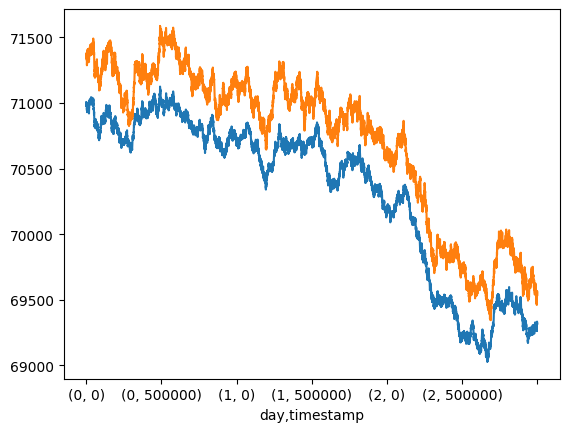

In [8]:
component_total.plot()
prices[prices['product']=='GIFT_BASKET']['mid_price'].plot()

<Axes: xlabel='day,timestamp'>

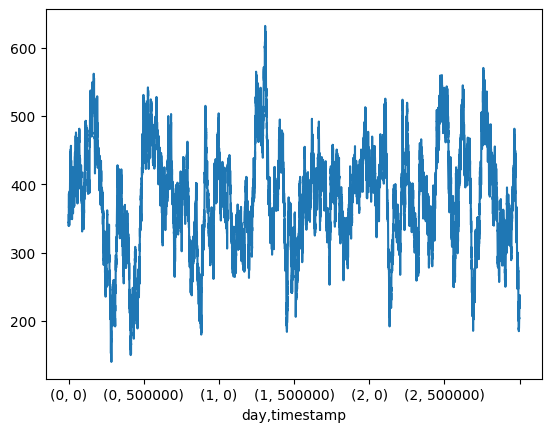

In [9]:
spread = prices[prices['product']=='GIFT_BASKET']['mid_price']-component_total
spread.plot()

In [10]:
spread.mean()

379.4904833333333

In [11]:
mid_price_all = prices.pivot_table(columns='product',values='mid_price',index=['day','timestamp'])

<Axes: xlabel='day,timestamp'>

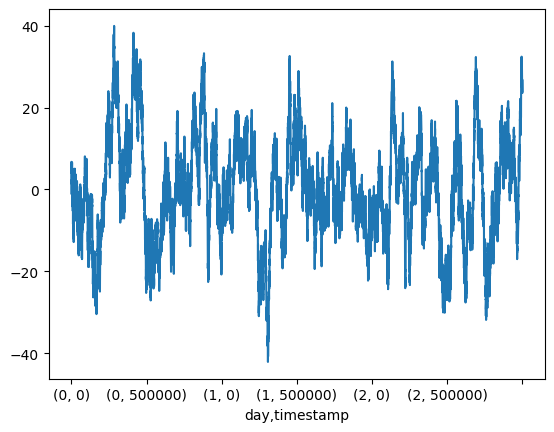

In [20]:
(mid_price_all['STRAWBERRIES']-(mid_price_all['GIFT_BASKET']-4*mid_price_all['CHOCOLATE']-mid_price_all['ROSES']-379.49)/6).plot()

<Axes: xlabel='day,timestamp'>

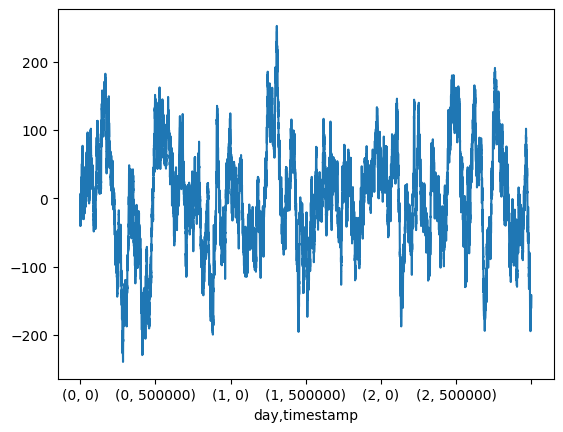

In [18]:
(spread-379.49).plot()

In [60]:

def ols(x, y, intercept=False):
    """
    Ordinary least squares regression for multivariate x, including R^2 and residuals.

    Args:
        x (list of lists or numpy.ndarray): 2D list or array where each inner list or
         row represents a single observation's features.
        y (list or numpy.ndarray): Output variable values, one for each observation.
        intercept (bool): Whether to include an intercept in the model. Default is False.
    Returns:
        dict: A dictionary containing coefficients, intercept, R^2, and residuals.
    """
    # Convert inputs to numpy arrays if they aren't already
    x = np.asarray(x)
    y = np.asarray(y)

    # Ensure x is two-dimensional (for a single predictor case, it should still work)
    if x.ndim == 1:
        x = x.reshape(-1, 1)

    if intercept:
        # Augment x with a column of ones for intercept
        X = np.hstack([np.ones((len(x), 1)), x])
    else:
        X = x

    # Compute X'X and X'Y
    XTX = X.T @ X
    XTY = X.T @ y.reshape(-1, 1)

    try:
        # Solve for beta (coefficients)
        beta = np.linalg.solve(XTX, XTY)
        beta = beta.flatten()  # Flatten the array to 1D

        # Calculate fitted values
        y_fitted = X @ beta.reshape(-1, 1)

        # Calculate residuals
        residuals = y.reshape(-1, 1) - y_fitted

        # Calculate R^2
        SS_res = residuals.T @ residuals
        SS_tot = (y.reshape(-1, 1) - np.mean(y)).T @ (y.reshape(-1, 1) - np.mean(y))
        r_squared = 1 - (SS_res / SS_tot).item()  # Extract scalar value
        if intercept:
            return {
                "coefficients": beta[1:],  # coefficients for predictors
                "intercept": beta[0],  # intercept
                "R2": r_squared,  # R^2 value
                "residuals": residuals.flatten(),  # residuals
            }
        else:
            return {
                "coefficients": beta,  # coefficients for predictors
                "R2": r_squared,  # R^2 value
                "residuals": residuals.flatten(),  # residuals
            }
    except np.linalg.LinAlgError:
        raise "Matrix is singular and cannot be inverted."

In [64]:
ols_res = ols(mid_price_all[['CHOCOLATE','STRAWBERRIES','ROSES']],mid_price_all['GIFT_BASKET'])

In [79]:
ols_res = ols(mid_price_all[['CHOCOLATE']],mid_price_all['GIFT_BASKET']-6*mid_price_all['STRAWBERRIES']-mid_price_all['ROSES']-479.490)

<Axes: xlabel='day,timestamp'>

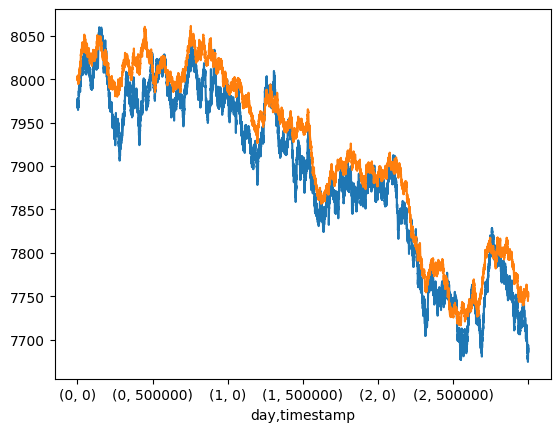

In [88]:
y_hat = ((mid_price_all['GIFT_BASKET']-6*mid_price_all['STRAWBERRIES']-mid_price_all['ROSES']-479.490)/4)
y_hat.plot()
mid_price_all['CHOCOLATE'].plot()

<Axes: xlabel='day,timestamp'>

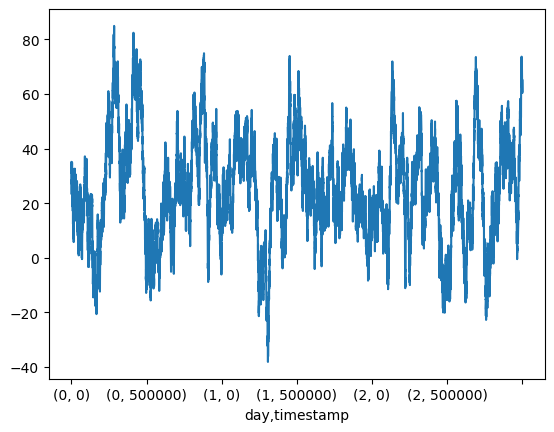

In [92]:
(mid_price_all['CHOCOLATE']-y_hat).plot()

In [94]:
np.corrcoef((mid_price_all['CHOCOLATE']-y_hat),spread)

array([[ 1., -1.],
       [-1.,  1.]])

In [82]:
mid_price_all[['CHOCOLATE']]

product        CHOCOLATE
day timestamp           
0   0             8000.0
    100           8001.5
    200           8001.0
    300           8002.5
    400           8002.0
...                  ...
2   999500        7750.5
    999600        7750.5
    999700        7750.5
    999800        7750.0
    999900        7750.0

[30000 rows x 1 columns]

In [78]:
spread.mean()

379.4904833333333

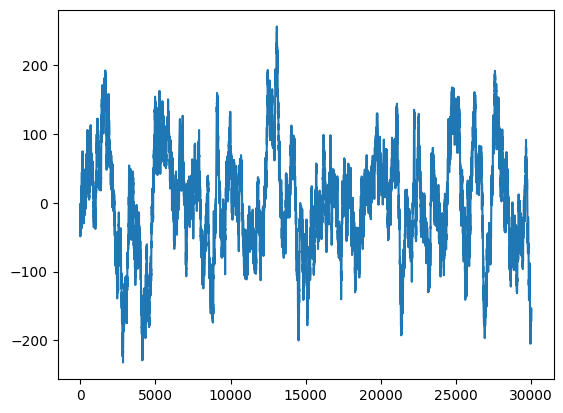

In [68]:
plt.plot(ols_res['residuals'])

<Axes: xlabel='day,timestamp'>

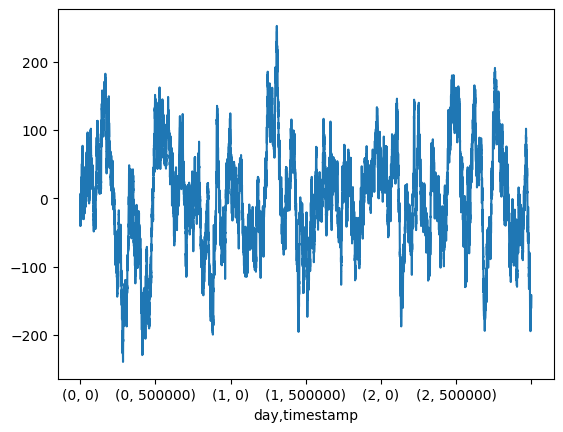

In [71]:
(spread-spread.mean()).plot()

In [63]:
np.corrcoef(component_total,prices[prices['product']=='GIFT_BASKET']['mid_price'])

array([[1.        , 0.99189699],
       [0.99189699, 1.        ]])

<Axes: xlabel='day,timestamp'>

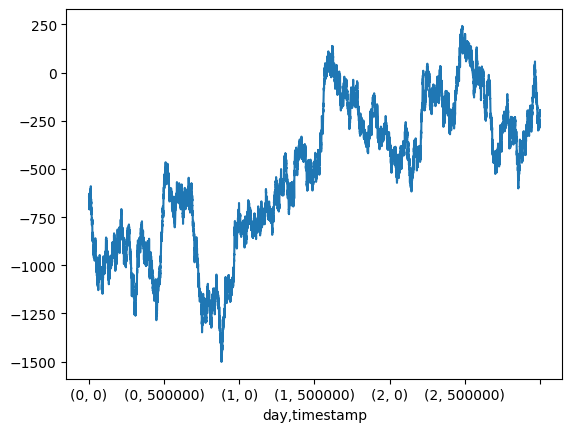

In [49]:
(prices[prices['product']=='GIFT_BASKET']['mid_price']-9*prices[prices['product']=='CHOCOLATE']['mid_price']).plot()

In [47]:
(prices[prices['product']=='GIFT_BASKET']['mid_price']/prices[prices['product']=='CHOCOLATE']['mid_price']).mean()

8.933633868419538